# Fitting point sources on the detector

In [1]:
# import modules
import funcs

import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# Define filename of observation in selected MRS band
band     = '1A'
sci_file = lvl2path+'FM1T00011453/MIRFM1T00011453_1_495_SE_2011-06-03T21h10m39_LVL2.fits'
bkg_file = lvl2path+'FM1T00011454/MIRFM1T00011454_1_495_SE_2011-06-04T00h23m34_LVL2.fits'

In [4]:
# Get data
hdulist_sci   = fits.open(sci_file)
hdulist_bkg   = fits.open(bkg_file)
source_signal = hdulist_sci[0].data[0,:,:]
backgr_signal = hdulist_bkg[0].data[0,:,:]

In [5]:
# load distortion map on detector plane
d2cMaps  = funcs.d2cMapping(band,cdpDir)
det_dims = (1024,1032)

In [6]:
# load CDPS
fringe_img,photom_img,pixsiz_img,psffits,specres_table = funcs.get_cdps(band,cdpDir,output='img')

In [7]:
# reduce LVL2 data to LVL3 data
source_signal_subtrbkg  = source_signal - backgr_signal         # [DN/s/pix_{ij}]
source_signal_divfringe = source_signal_subtrbkg/fringe_img     # [DN/s/pix_{ij}]

In [8]:
# create spectral grid on detector
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

In [9]:
if band[0] == '4': fit = '1D'
else: fit = '2D'

if band[0] == '4':
    centroid = funcs.point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit)
    if len(np.where(np.isnan(sign_amp)==True)[0]) > len(lambcens)/2:
        # too many nans.. last attempt
        centroid = funcs.point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit,center=[d2cMaps['nslices']/2,0.])
else:
    centroid = funcs.point_source_centroiding(band,source_signal_divfringe,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit)

STEP 1: Rough centroiding
Slice 12 has the largest summed flux
Source position: beta = 0.18arcsec, alpha = -0.24arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 39, 40, 41, 43, 121, 122, 123, 197, 203, 295, 296, 304, 305, 306, 345, 346, 347, 348, 371, 372, 373, 374, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]


<IPython.core.display.Javascript object>


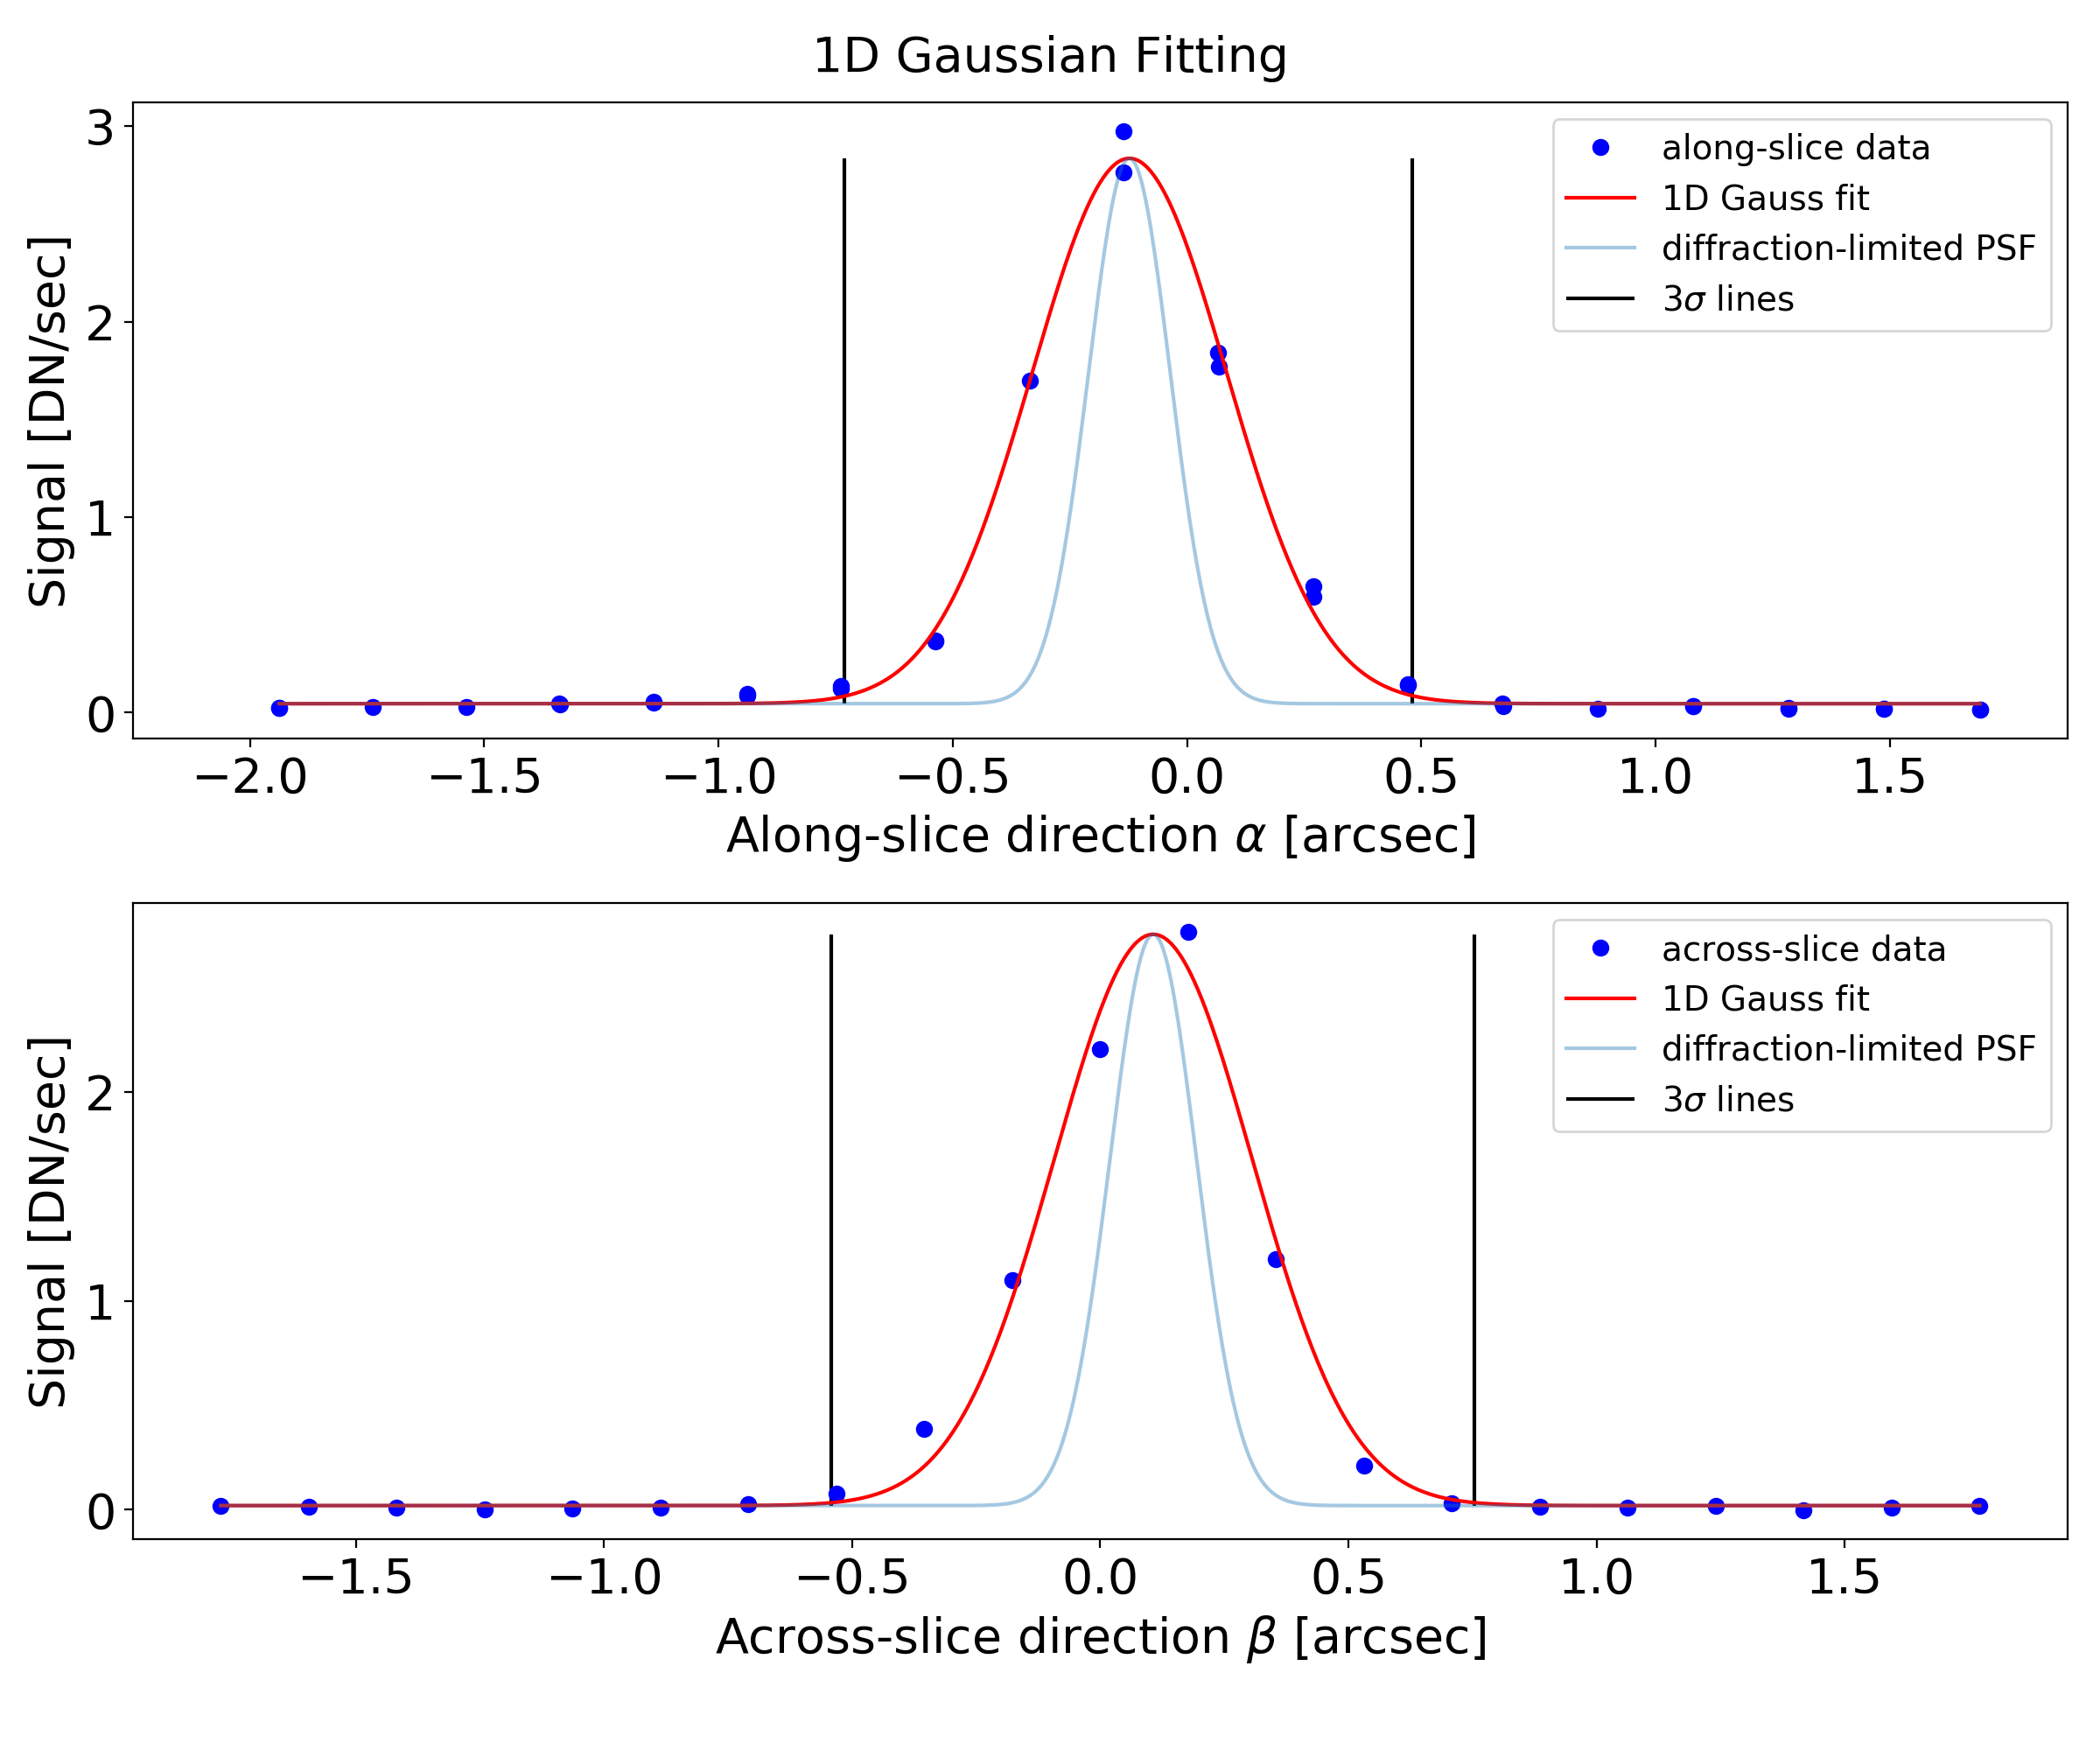

<IPython.core.display.Javascript object>


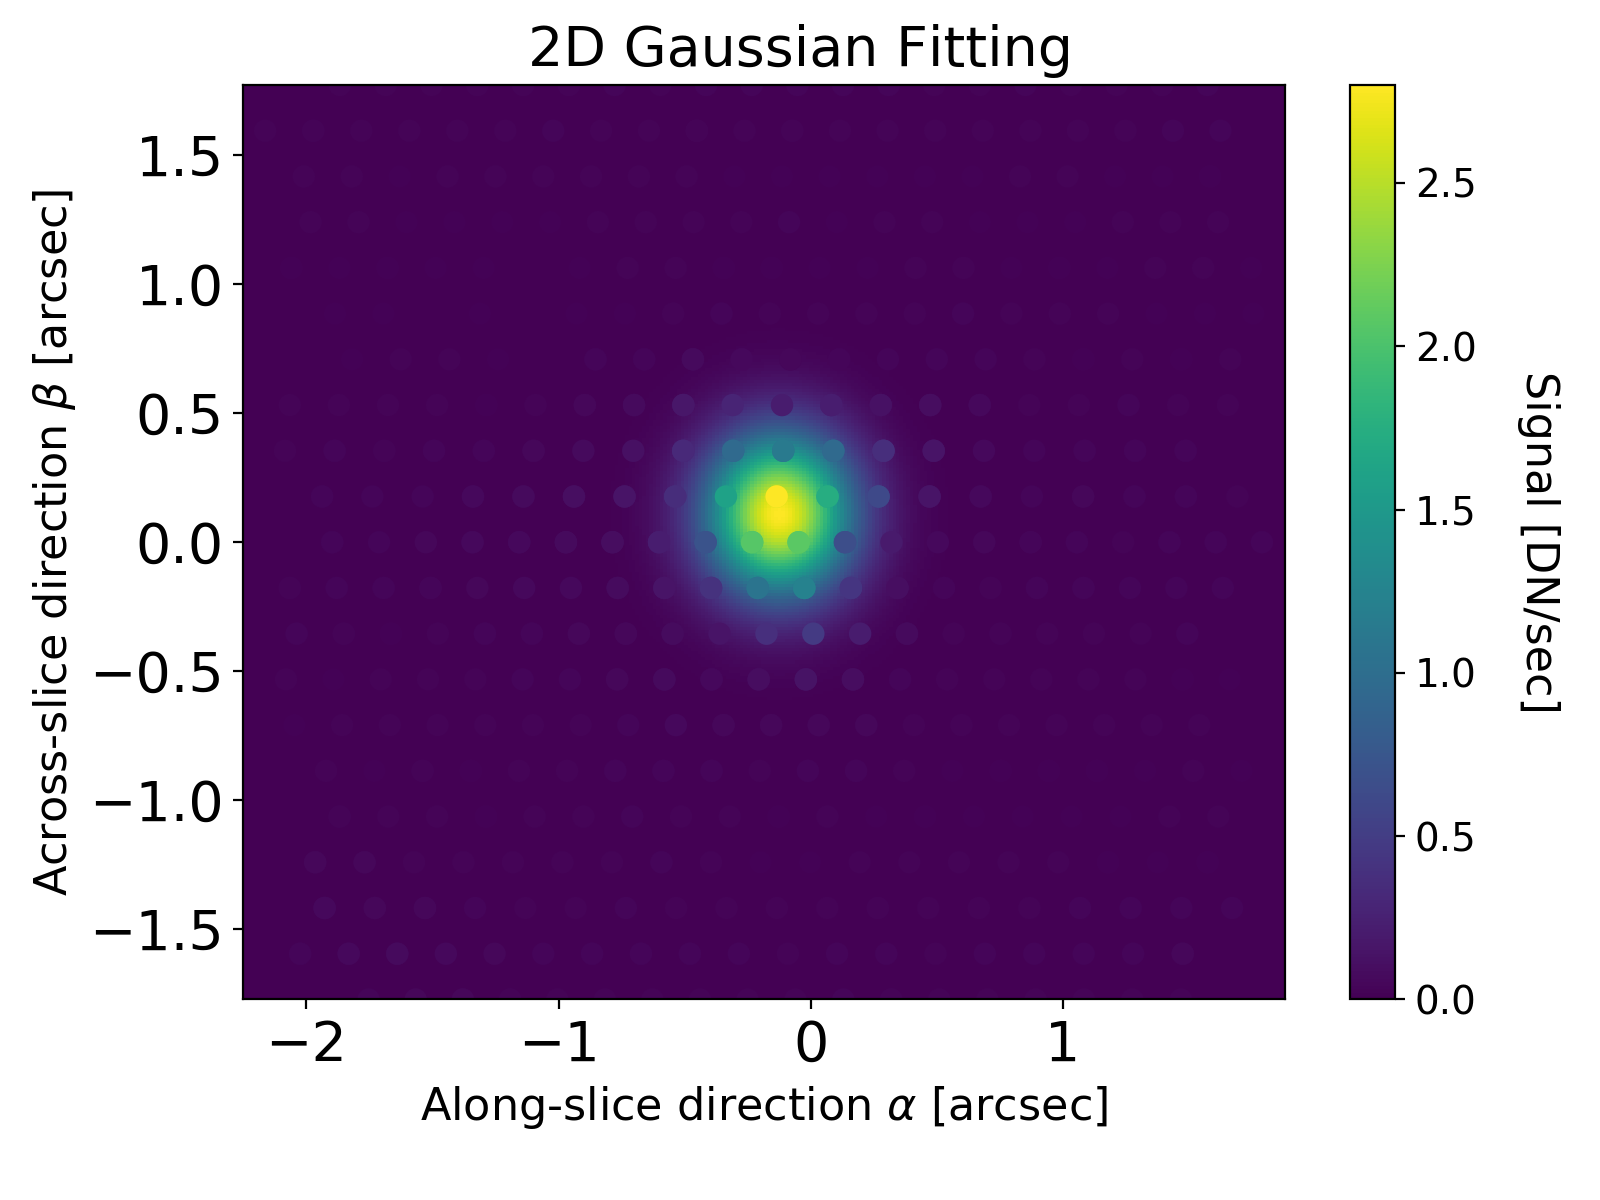

<IPython.core.display.Javascript object>


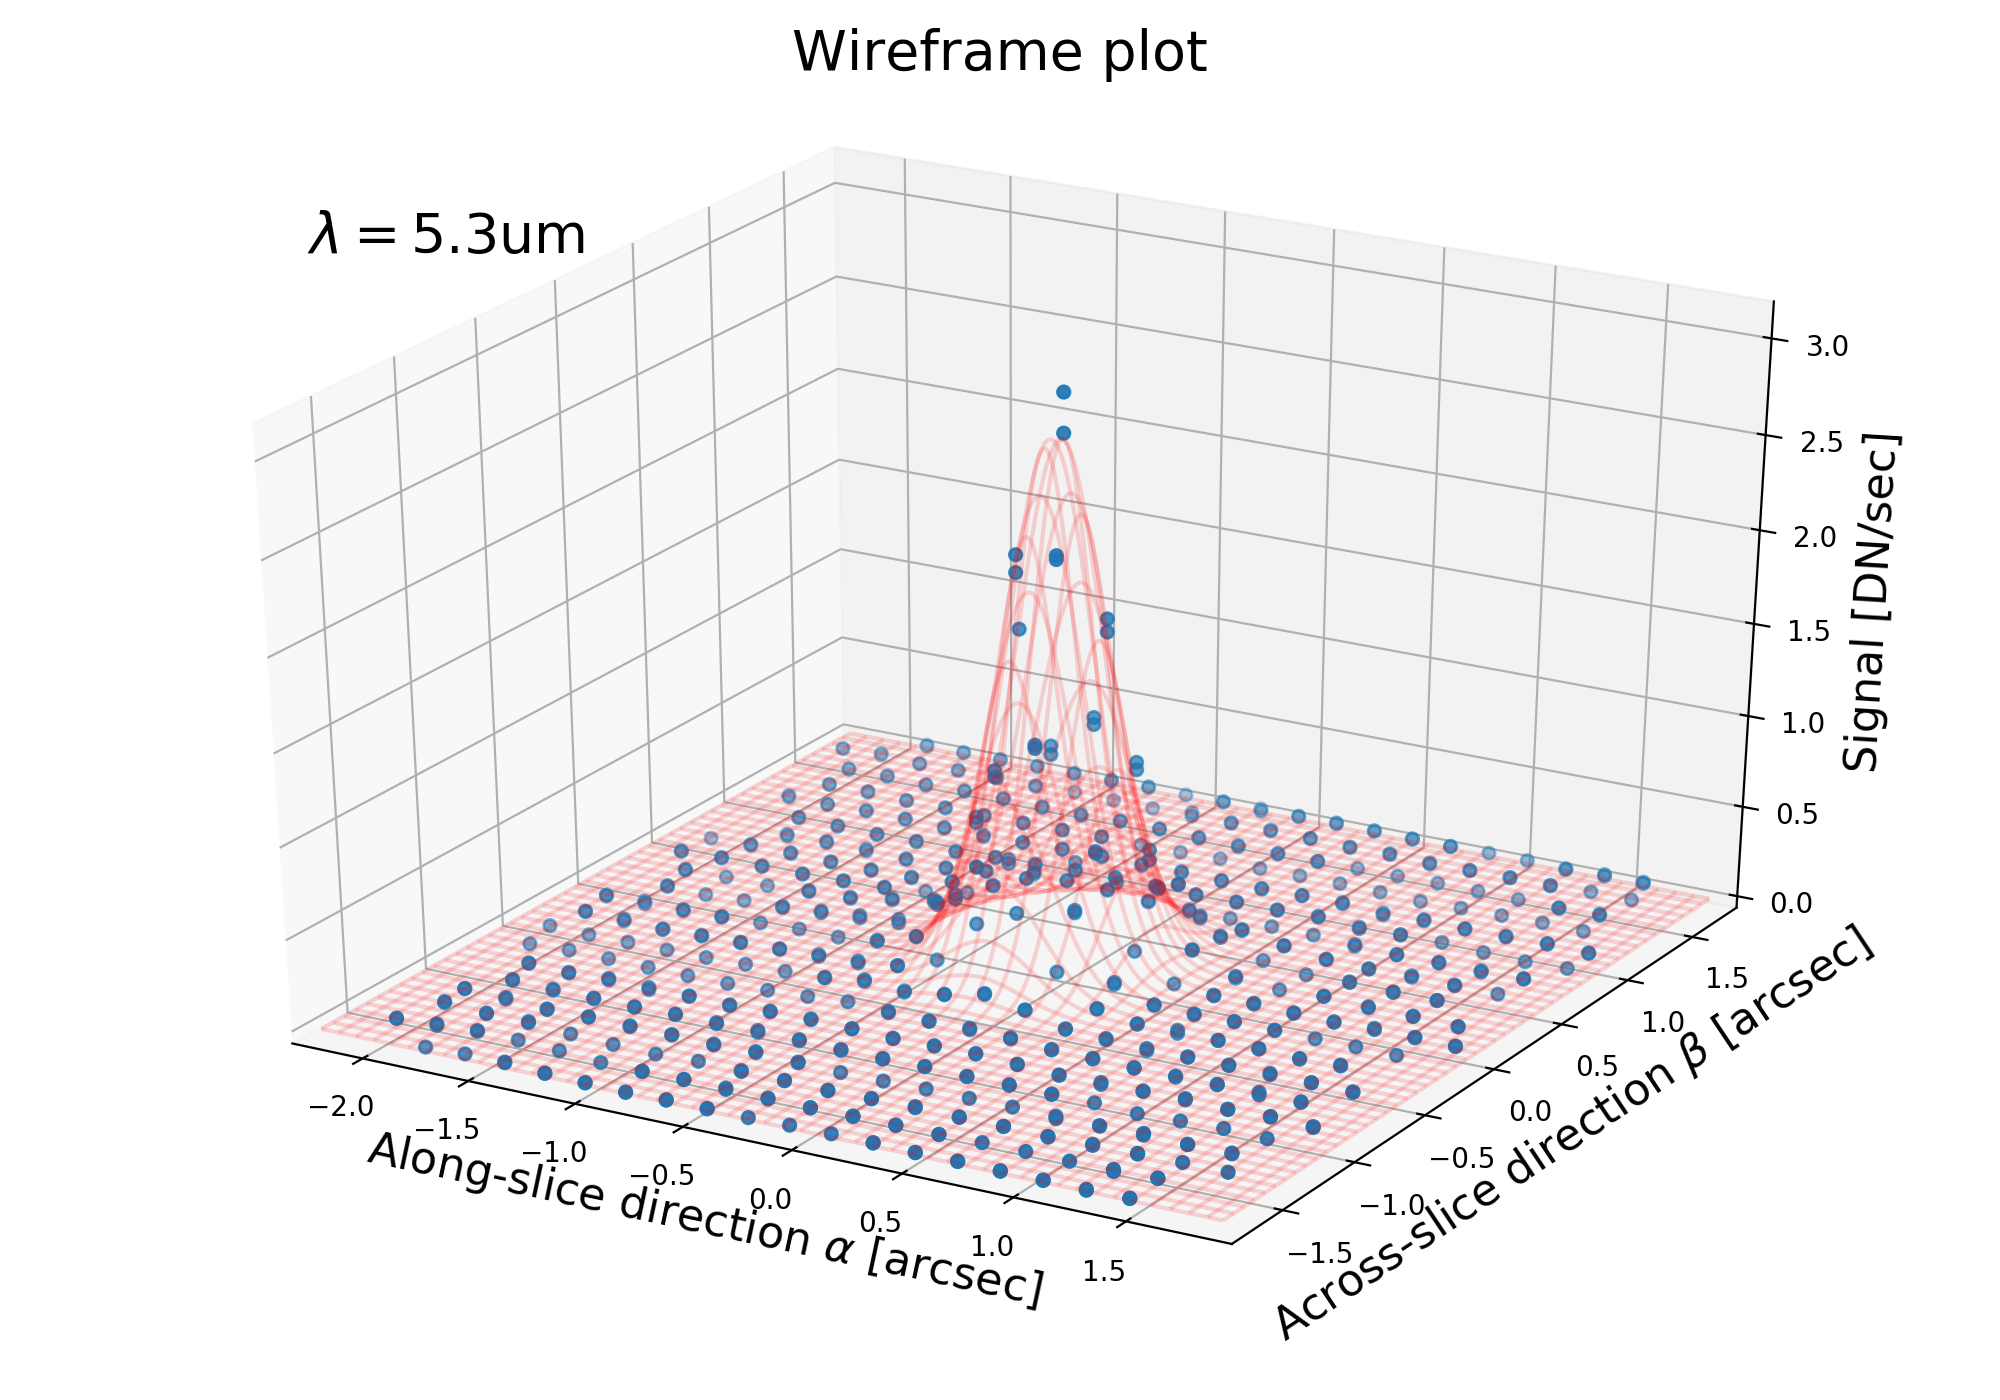

<IPython.core.display.Javascript object>


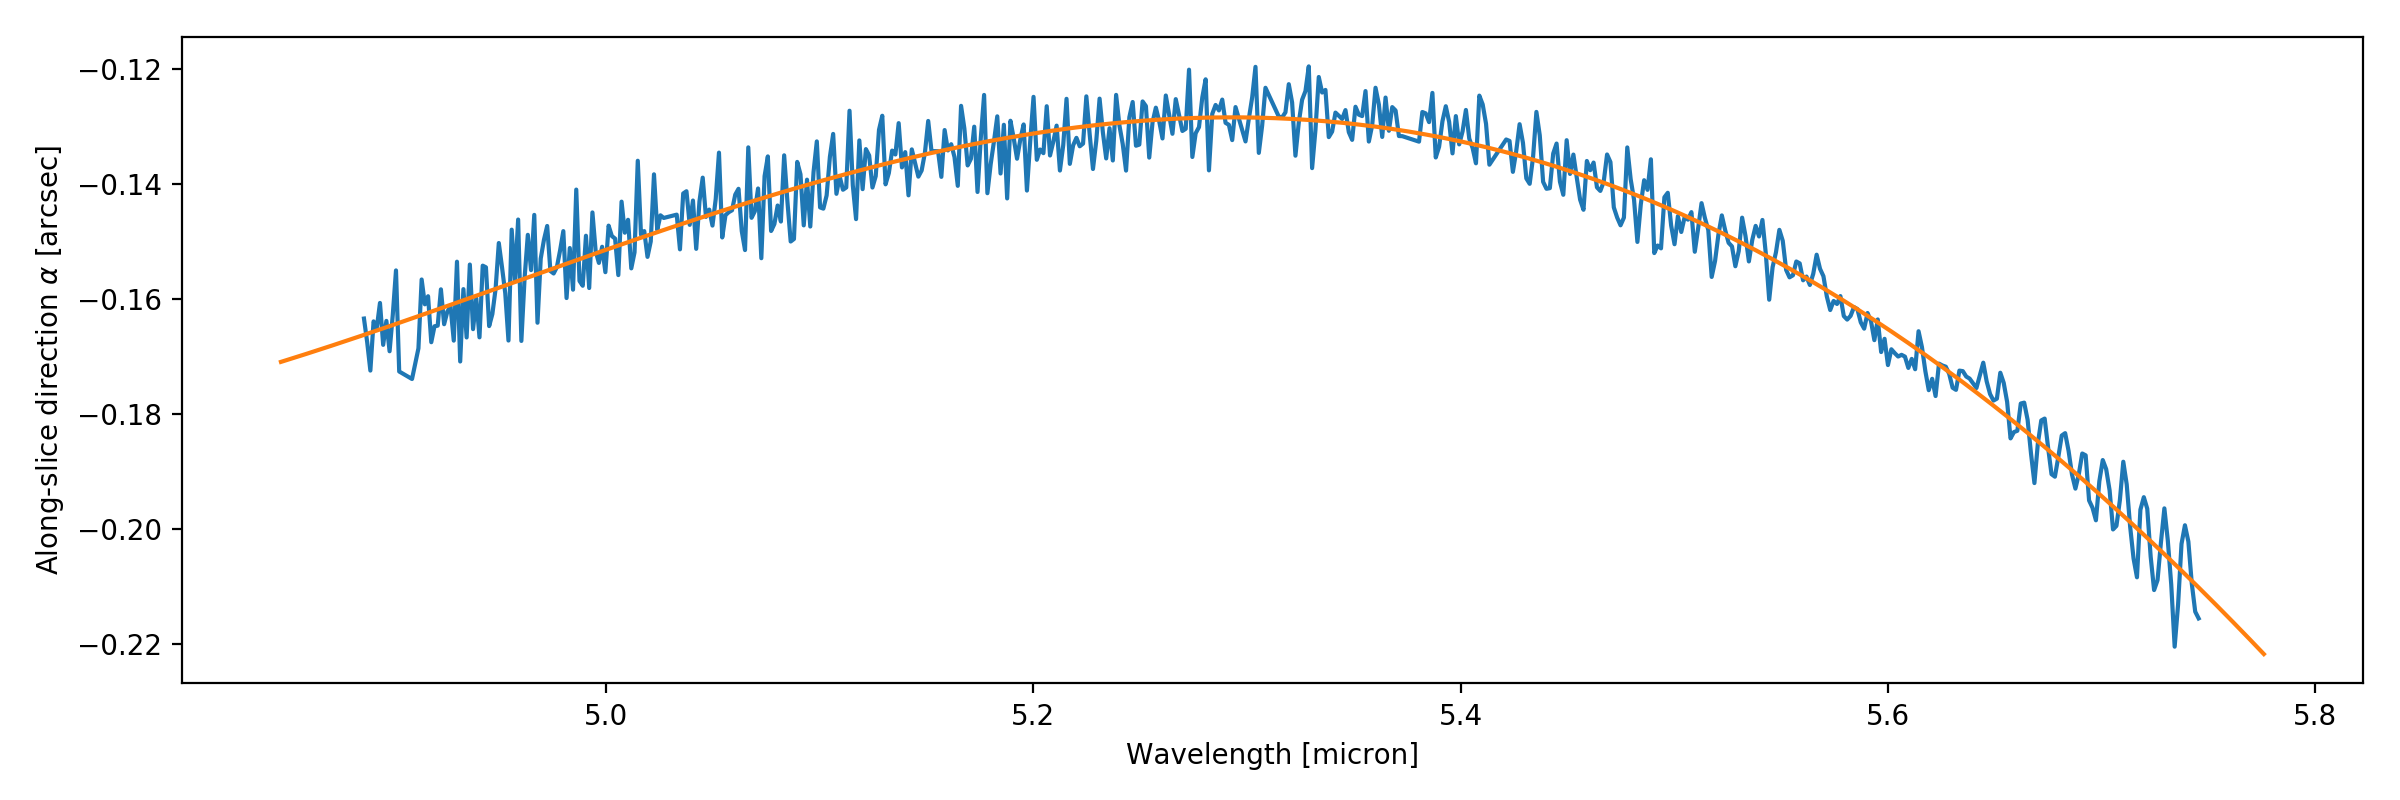

In [10]:
# plot results
ibin = len(lambcens)/2
if band[0] == '4':
    funcs.plot_point_source_centroiding(band,source_signal_subtrbkg,d2cMaps,spec_grid=[lambcens,lambfwhms],centroid=centroid,ibin=ibin,data='slope')
else:
    funcs.plot_point_source_centroiding(band,source_signal_divfringe,d2cMaps,spec_grid=[lambcens,lambfwhms],centroid=centroid,ibin=ibin,data='slope')
    
# along-slice centroid
alphacens = centroid[1]
sel = ~np.isnan(alphacens)

popt,pcov = curve_fit(funcs.order4polyfit,lambcens[sel],alphacens[sel])

plt.figure(figsize=(12,4))
plt.plot(lambcens[sel],alphacens[sel])
plt.plot(lambcens,funcs.order4polyfit(lambcens,*popt))
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Along-slice direction $\alpha$ [arcsec]')
plt.tight_layout()